### **Car Damage Detection**

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)), #Resizing the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229,0.224,0.225])  # i took it from image.net datasets each **R, G, B**

])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path= "/content/drive/MyDrive/Colab Notebooks/Car_Damage_detection/dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2473

In [ ]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [ ]:
num_classes = len(dataset.classes)
num_classes

6

**Datasets classes has**
1) F_Breakage = Front Breakage,
2) F_Crushed'= Front Crushed,
3) F_Normal = Front Normal,
4) R_Breakage = Right Breakage,
5) R_Crushed = Right Crushed,
6) R_Normal = Right Normal

In [ ]:


train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size,val_size

(1854, 619)

In [ ]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
class_names = train_dataset.dataset.classes
print(class_names)


['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
for image, labels in train_loader:
  print(image.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32])


32 is image size, 3 is RGB, 224 * 224 = W * L

In [ ]:
labels[0]

tensor(4)

**tensor[5] classes of 'R_Crushed'**

In [ ]:
image[0].shape

torch.Size([3, 224, 224])

In [ ]:
image[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

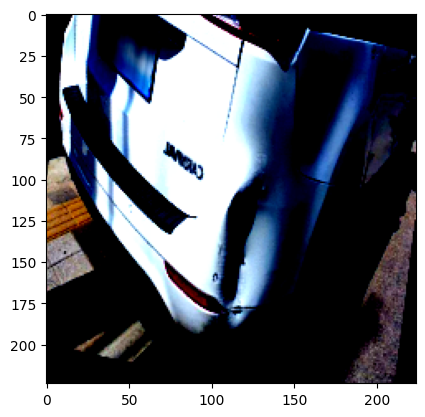

In [ ]:
plt.imshow(image[0].permute(1,2,0))

### **Model 1 : CNN**

In [ ]:
                                                                      #-------------------Model CNN------------------#
# ==========================================================
# CarClassifierCNN
# Purpose: Multi-class car damage image classification
# Input  : RGB image (3 x 224 x 224)
# Output : Raw class scores (logits)
# ==========================================================
class CarClassifierCNN(nn.Module):

    def __init__(self, num_classes):
        # IMPORTANT: Always call parent class constructor
        super().__init__()

        # ==================================================
        # Feature Extractor + Classifier combined
        # ==================================================
        self.network = nn.Sequential(

            # ==================================================
            # 🔹 CONVOLUTION BLOCK 1 (LOW-LEVEL FEATURES)
            # Learns edges, corners, textures
            # ==================================================

            nn.Conv2d(
                in_channels=3,        #  RGB image
                out_channels=16,      #  number of learned filters
                kernel_size=3,        #  local receptive field
                stride=1,
                padding=1             #  keeps spatial size same
            ),  # Output → (B, 16, 224, 224)

            nn.ReLU(),               #  introduces non-linearity

            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),  #  Downsampling → (B, 16, 112, 112)

            # ==================================================
            # 🔹 CONVOLUTION BLOCK 2 (MID-LEVEL FEATURES)
            # Learns dents, scratches, breakage patterns
            # ==================================================

            nn.Conv2d(
                in_channels=16,
                out_channels=32,      #  increased depth = richer features
                kernel_size=3,
                stride=1,
                padding=1
            ),  # Output → (B, 32, 112, 112)

            nn.ReLU(),

            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),  #  (B, 32, 56, 56)

            # ==================================================
            # 🔹 CONVOLUTION BLOCK 3 (HIGH-LEVEL FEATURES)
            # Learns complex damage structures
            # ==================================================

            nn.Conv2d(
                in_channels=32,
                out_channels=64,      #  deeper semantic features
                kernel_size=3,
                stride=1,
                padding=1
            ),  # Output → (B, 64, 56, 56)

            nn.ReLU(),

            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),  #  (B, 64, 28, 28)

            # ==================================================
            # 🔹 FLATTENING (CRITICAL TRANSITION)
            # Converts spatial features → vector
            # ==================================================

            nn.Flatten(),            #  64×28×28 = 50176 features

            # ==================================================
            # 🔹 FULLY CONNECTED LAYER
            # Learns global image representation
            # ==================================================

            nn.Linear(
                in_features=64 * 28 * 28,
                out_features=512      #  feature compression
            ),

            nn.ReLU(),

            # ==================================================
            # 🔹 OUTPUT LAYER (VERY IMPORTANT)
            # Produces RAW SCORES (logits)
            # ==================================================

            nn.Linear(
                in_features=512,
                out_features=num_classes   #  must match number of classes
            )
            # NO SOFTMAX HERE (intentional)
        )

    # ==================================================
    # FORWARD PASS
    # Defines how data flows through the network
    # ==================================================
    def forward(self, x):
        return self.network(x)


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):

    # --------------------------------------------------
    # Track total training time
    # --------------------------------------------------
    start = time.time()

    # ==================================================
    # TRAINING LOOP (EPOCH LEVEL)
    # ==================================================
    for epoch in range(epochs):

        # VERY IMPORTANT
        # Enables dropout & batchnorm (if present)
        model.train()

        running_loss = 0.0  # Tracks total loss for the epoch

        # ==================================================
        # TRAINING LOOP (BATCH LEVEL)
        # ==================================================
        for batch_num, (images, labels) in enumerate(train_loader):

            #  Move data to GPU/CPU
            images, labels = images.to(device), labels.to(device)

            # --------------------------------------------------
            # Reset gradients from previous iteration
            # --------------------------------------------------
            optimizer.zero_grad()

            # --------------------------------------------------
            # FORWARD PASS
            # Model produces raw scores (logits)
            # --------------------------------------------------
            outputs = model(images)

            # --------------------------------------------------
            # LOSS COMPUTATION
            # CrossEntropyLoss applies Softmax internally
            # --------------------------------------------------
            loss = criterion(outputs, labels)

            # --------------------------------------------------
            # BACKWARD PASS
            # Computes gradients using backpropagation
            # --------------------------------------------------
            loss.backward()

            # --------------------------------------------------
            # PARAMETER UPDATE
            # Optimizer updates model weights
            # --------------------------------------------------
            optimizer.step()

            #  Print loss every 10 batches
            if (batch_num + 1) % 10 == 0:
                print(
                    f"Batch: {batch_num+1}, "
                    f"Epoch: {epoch+1}, "
                    f"Loss: {loss.item():0.2f}"
                )

            # Accumulate loss for epoch average
            running_loss += loss.item() * images.size(0)

        # --------------------------------------------------
        # AVERAGE TRAINING LOSS FOR THE EPOCH
        # --------------------------------------------------
        epoch_loss = running_loss / len(train_loader.dataset)

        print(
            f"Epoch [{epoch+1}/{epochs}], "
            f"Avg Loss: {epoch_loss:.4f}"
        )

        # ==================================================
        # VALIDATION PHASE
        # ==================================================

        #  Switch to evaluation mode
        # Disables dropout & batchnorm updates
        model.eval()

        correct = 0
        total = 0

        # Store predictions for metrics (confusion matrix, etc.)
        all_labels = []
        all_predictions = []

        # --------------------------------------------------
        # Disable gradient calculation (saves memory & time)
        # --------------------------------------------------
        with torch.no_grad():

            for images, labels in val_loader:

                # Move validation data to device
                images, labels = images.to(device), labels.to(device)

                # Forward pass only (NO backprop)
                outputs = model(images)

                # Get class with highest score
                _, predicted = torch.max(outputs.data, 1)

                # Count total samples
                total += labels.size(0)

                # Count correct predictions
                correct += (predicted == labels).sum().item()

                # Store for later analysis
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            # --------------------------------------------------
            # VALIDATION ACCURACY
            # --------------------------------------------------
            print(
                f"*** Validation Accuracy: "
                f"{100 * correct / total:.2f}% ***"
            )

    # ==================================================
    # TRAINING TIME
    # ==================================================
    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")

    # Return labels & predictions for evaluation
    return all_labels, all_predictions



In [ ]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    epochs=10
)

Batch: 10, Epoch: 1, Loss: 1.81
Batch: 20, Epoch: 1, Loss: 1.89
Batch: 30, Epoch: 1, Loss: 1.55
Batch: 40, Epoch: 1, Loss: 1.57
Batch: 50, Epoch: 1, Loss: 1.65
Epoch [1/10], Avg Loss: 1.8062
*** Validation Accuracy: 44.75% ***
Batch: 10, Epoch: 2, Loss: 1.32
Batch: 20, Epoch: 2, Loss: 1.05
Batch: 30, Epoch: 2, Loss: 1.20
Batch: 40, Epoch: 2, Loss: 0.96
Batch: 50, Epoch: 2, Loss: 1.04
Epoch [2/10], Avg Loss: 1.2323
*** Validation Accuracy: 51.21% ***
Batch: 10, Epoch: 3, Loss: 1.11
Batch: 20, Epoch: 3, Loss: 1.07
Batch: 30, Epoch: 3, Loss: 1.26
Batch: 40, Epoch: 3, Loss: 1.05
Batch: 50, Epoch: 3, Loss: 1.00
Epoch [3/10], Avg Loss: 1.0750
*** Validation Accuracy: 54.77% ***
Batch: 10, Epoch: 4, Loss: 0.70
Batch: 20, Epoch: 4, Loss: 0.79
Batch: 30, Epoch: 4, Loss: 0.97
Batch: 40, Epoch: 4, Loss: 0.96
Batch: 50, Epoch: 4, Loss: 0.81
Epoch [4/10], Avg Loss: 0.9537
*** Validation Accuracy: 57.35% ***
Batch: 10, Epoch: 5, Loss: 1.09
Batch: 20, Epoch: 5, Loss: 1.03
Batch: 30, Epoch: 5, Loss: 1

**Validation Loss** Average High and the **Validation Accuracy** is Low which clearly states that the model is **Overfitting**

### **Model 2 : CNN with Regularization**

In [ ]:
# ==========================================================
# CarClassifierCNNWithRegularization
# Purpose:
#   - Multi-class car damage classification
#   - Uses Batch Normalization + Dropout to reduce overfitting
#
# Input:
#   - RGB image of size (3 x 224 x 224)
#
# Output:
#   - Raw class scores (logits)
# ==========================================================
class CarClassifierCNNWithRegularization(nn.Module):

    def __init__(self, num_classes):
        # --------------------------------------------------
        # Initialize parent class (MANDATORY)
        # --------------------------------------------------
        super().__init__()

        # --------------------------------------------------
        # Feature extractor + classifier in one Sequential
        # --------------------------------------------------
        self.network = nn.Sequential(

            # ==================================================
            # 🔹 CONVOLUTION BLOCK 1 (LOW-LEVEL FEATURES)
            # ==================================================

            # Convolution:
            # - Input channels: 3 (RGB)
            # - Output channels: 16 feature maps
            # - Kernel 3x3 captures local textures and edges
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),  # Output shape: (Batch, 16, 224, 224)

            # Batch Normalization:
            # - Normalizes activations
            # - Stabilizes training
            # - Allows higher learning rates
            nn.BatchNorm2d(16), # For Regularization Technique 1

            # ReLU:
            # - Introduces non-linearity
            nn.ReLU(),

            # Max Pooling:
            # - Reduces spatial dimension by half
            # - Keeps strongest features
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),  # Output shape: (Batch, 16, 112, 112)

            # ==================================================
            # 🔹 CONVOLUTION BLOCK 2 (MID-LEVEL FEATURES)
            # ==================================================

            # Learns damage patterns like scratches and dents
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),  # Output shape: (Batch, 32, 112, 112)

            # Batch normalization for stable gradients
            nn.BatchNorm2d(32),

            # Non-linearity
            nn.ReLU(),

            # Downsampling
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),  # Output shape: (Batch, 32, 56, 56)

            # ==================================================
            # 🔹 CONVOLUTION BLOCK 3 (HIGH-LEVEL FEATURES)
            # ==================================================

            # Learns complex structural damage features
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),  # Output shape: (Batch, 64, 56, 56)

            # Batch normalization reduces internal covariate shift
            nn.BatchNorm2d(64),

            # Non-linearity
            nn.ReLU(),

            # Spatial reduction
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),  # Output shape: (Batch, 64, 28, 28)

            # ==================================================
            # 🔹 FLATTENING (CRITICAL TRANSITION)
            # ==================================================

            # Converts feature maps into a single vector
            # 64 * 28 * 28 = 50176 features
            nn.Flatten(),

            # ==================================================
            # 🔹 FULLY CONNECTED LAYER
            # ==================================================

            # Compresses high-dimensional features
            nn.Linear(
                in_features=64 * 28 * 28,
                out_features=512
            ),

            # Non-linearity
            nn.ReLU(),

            # Dropout:
            # - Randomly drops 50% neurons during training
            # - Prevents co-adaptation
            # - Strong regularization against overfitting
            nn.Dropout(p=0.5), # For Regularization Technique 2

            # ==================================================
            # 🔹 OUTPUT LAYER
            # ==================================================

            # Produces one logit per class
            nn.Linear(
                in_features=512,
                out_features=num_classes
            )
            # NO SOFTMAX HERE
            # CrossEntropyLoss handles it internally
        )

    # --------------------------------------------------
    # Forward Pass
    # --------------------------------------------------
    def forward(self, x):
        # Pass input through entire network
        return self.network(x)

In [ ]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4 # For Regularization Technique 3)

all_labels, all_predictions = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    epochs=10
)

Batch: 10, Epoch: 1, Loss: 11.42
Batch: 20, Epoch: 1, Loss: 5.83
Batch: 30, Epoch: 1, Loss: 2.06
Batch: 40, Epoch: 1, Loss: 2.16
Batch: 50, Epoch: 1, Loss: 1.56
Epoch [1/10], Avg Loss: 5.7725
*** Validation Accuracy: 44.26% ***
Batch: 10, Epoch: 2, Loss: 1.16
Batch: 20, Epoch: 2, Loss: 1.52
Batch: 30, Epoch: 2, Loss: 1.38
Batch: 40, Epoch: 2, Loss: 1.30
Batch: 50, Epoch: 2, Loss: 1.19
Epoch [2/10], Avg Loss: 1.3116
*** Validation Accuracy: 45.56% ***
Batch: 10, Epoch: 3, Loss: 1.25
Batch: 20, Epoch: 3, Loss: 1.22
Batch: 30, Epoch: 3, Loss: 1.36
Batch: 40, Epoch: 3, Loss: 1.58
Batch: 50, Epoch: 3, Loss: 1.34
Epoch [3/10], Avg Loss: 1.2216
*** Validation Accuracy: 48.63% ***
Batch: 10, Epoch: 4, Loss: 1.53
Batch: 20, Epoch: 4, Loss: 1.33
Batch: 30, Epoch: 4, Loss: 1.09
Batch: 40, Epoch: 4, Loss: 1.20
Batch: 50, Epoch: 4, Loss: 1.21
Epoch [4/10], Avg Loss: 1.1856
*** Validation Accuracy: 49.60% ***
Batch: 10, Epoch: 5, Loss: 1.12
Batch: 20, Epoch: 5, Loss: 0.81
Batch: 30, Epoch: 5, Loss: 

**Here the Regularization Technique Validation Accuracy is not improving and it still Overfitting**

-----------------------


**The primary resource for computer vision models in PyTorch is the torchvision.models subpackage.**

**Image Classification:** Common models include AlexNet, ResNet (e.g., ResNet18, ResNet50), VGG, DenseNet, Inception V3, MobileNet V2/V3, EfficientNet, and Vision Transformer (ViT). These are typically pretrained on the ImageNet dataset.

**Object Detection, Segmentation, and Keypoint Detection**: Models for these tasks (e.g., Faster R-CNN, Mask R-CNN) are also available, often pretrained on the COCO dataset.

--------------------------------------------------------------

**Model 3: Transfer Learning with EfficientNet**

First im trying with this Model

In [ ]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


1280

In [ ]:
# ==========================================================
# CarClassifierEfficientNet
# Purpose:
#   - Multi-class car damage classification
#   - Uses EfficientNet-B0 with Transfer Learning
#
# Key Idea:
#   - Reuse pretrained ImageNet features
#   - Train only the final classifier layer
#
# Input:
#   - RGB image (3 x 224 x 224)
#
# Output:
#   - Raw class scores (logits)
# ==========================================================
class CarClassifierEfficientNet(nn.Module):

    def __init__(self, num_classes):
        # --------------------------------------------------
        # Initialize parent nn.Module
        # --------------------------------------------------
        super().__init__()

        # --------------------------------------------------
        # Load EfficientNet-B0 pretrained on ImageNet
        # --------------------------------------------------
        # weights='DEFAULT' loads ImageNet-trained weights
        self.model = models.efficientnet_b0(weights='DEFAULT')

        # --------------------------------------------------
        # FREEZE ALL PRETRAINED WEIGHTS
        # --------------------------------------------------
        # This prevents updating convolutional layers
        # Useful when dataset is small
        for param in self.model.parameters():
            param.requires_grad = False

        # --------------------------------------------------
        # Get input feature size of the original classifier
        # --------------------------------------------------
        # EfficientNet classifier structure:
        # classifier = [Dropout, Linear]
        in_features = self.model.classifier[1].in_features

        # --------------------------------------------------
        # REPLACE CLASSIFIER HEAD
        # --------------------------------------------------
        # Custom classifier for car damage classes
        self.model.classifier = nn.Sequential(

            # Dropout:
            # - Reduces overfitting
            # - Only active during training
            nn.Dropout(p=0.5),

            # Final Linear Layer:
            # - Maps extracted features to num_classes
            nn.Linear(
                in_features=in_features,
                out_features=num_classes
            )
            #  NO SOFTMAX HERE
            # CrossEntropyLoss handles it internally
        )

    # --------------------------------------------------
    # Forward Pass
    # --------------------------------------------------
    def forward(self, x):
        # Input flows through EfficientNet backbone
        # then through the custom classifier head
        return self.model(x)


In [ ]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    epochs=10
)

Batch: 10, Epoch: 1, Loss: 1.77
Batch: 20, Epoch: 1, Loss: 1.44
Batch: 30, Epoch: 1, Loss: 1.34
Batch: 40, Epoch: 1, Loss: 1.29
Batch: 50, Epoch: 1, Loss: 1.13
Epoch [1/10], Avg Loss: 1.4422
*** Validation Accuracy: 56.70% ***
Batch: 10, Epoch: 2, Loss: 1.29
Batch: 20, Epoch: 2, Loss: 1.23
Batch: 30, Epoch: 2, Loss: 1.05
Batch: 40, Epoch: 2, Loss: 0.92
Batch: 50, Epoch: 2, Loss: 1.16
Epoch [2/10], Avg Loss: 1.1106
*** Validation Accuracy: 62.36% ***
Batch: 10, Epoch: 3, Loss: 0.92
Batch: 20, Epoch: 3, Loss: 0.92
Batch: 30, Epoch: 3, Loss: 0.97
Batch: 40, Epoch: 3, Loss: 0.87
Batch: 50, Epoch: 3, Loss: 0.97
Epoch [3/10], Avg Loss: 0.9815
*** Validation Accuracy: 63.81% ***
Batch: 10, Epoch: 4, Loss: 0.84
Batch: 20, Epoch: 4, Loss: 1.17
Batch: 30, Epoch: 4, Loss: 0.89
Batch: 40, Epoch: 4, Loss: 0.88
Batch: 50, Epoch: 4, Loss: 0.88
Epoch [4/10], Avg Loss: 0.9249
*** Validation Accuracy: 66.56% ***
Batch: 10, Epoch: 5, Loss: 0.77
Batch: 20, Epoch: 5, Loss: 1.07
Batch: 30, Epoch: 5, Loss: 0

**Model 4: Transfer Learning with ResNet**

In [ ]:
# ==========================================================
# CarClassifierResNet
# Purpose:
#   - Multi-class car damage classification
#   - Uses ResNet-50 with transfer learning
#   - Partially fine-tunes deeper layers
#
# Input:
#   - RGB image (3 x 224 x 224)
#
# Output:
#   - Raw class scores (logits)
# ==========================================================
class CarClassifierResNet(nn.Module):

    def __init__(self, num_classes, dropout_rate=0.5):
        # --------------------------------------------------
        # Initialize parent class
        # --------------------------------------------------
        super().__init__()

        # --------------------------------------------------
        # Load ResNet-50 pretrained on ImageNet
        # --------------------------------------------------
        # weights='DEFAULT' loads ImageNet weights
        self.model = models.resnet50(weights='DEFAULT')

        # --------------------------------------------------
        # FREEZE ALL PRETRAINED PARAMETERS
        # --------------------------------------------------
        # Prevents updating early and mid-level features
        # Useful when dataset size is limited
        for param in self.model.parameters():
            param.requires_grad = False

        # --------------------------------------------------
        # UNFREEZE LAST RESIDUAL BLOCK (layer4)
        # --------------------------------------------------
        # Allows fine-tuning of high-level features
        # layer4 captures task-specific semantics
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # --------------------------------------------------
        # REPLACE FINAL FULLY CONNECTED LAYER
        # --------------------------------------------------
        # Original FC outputs 1000 ImageNet classes
        # We replace it with a custom classifier
        self.model.fc = nn.Sequential(

            # Dropout:
            # - Reduces overfitting
            # - Randomly disables neurons during training
            nn.Dropout(p=dropout_rate),

            # Linear layer:
            # - Maps ResNet features to num_classes
            nn.Linear(
                in_features=self.model.fc.in_features,
                out_features=num_classes
            )
            # NO Softmax here
            # CrossEntropyLoss handles it internally
        )

    # --------------------------------------------------
    # Forward Pass
    # --------------------------------------------------
    def forward(self, x):
        # Input passes through ResNet backbone
        # then through the custom classifier head
        return self.model(x)

In [ ]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    epochs=10
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


Batch: 10, Epoch: 1, Loss: 1.03
Batch: 20, Epoch: 1, Loss: 0.88
Batch: 30, Epoch: 1, Loss: 0.66
Batch: 40, Epoch: 1, Loss: 0.91
Batch: 50, Epoch: 1, Loss: 0.52
Epoch [1/10], Avg Loss: 0.8473
*** Validation Accuracy: 77.22% ***
Batch: 10, Epoch: 2, Loss: 0.54
Batch: 20, Epoch: 2, Loss: 0.52
Batch: 30, Epoch: 2, Loss: 0.48
Batch: 40, Epoch: 2, Loss: 0.89
Batch: 50, Epoch: 2, Loss: 0.52
Epoch [2/10], Avg Loss: 0.4566
*** Validation Accuracy: 75.28% ***
Batch: 10, Epoch: 3, Loss: 0.32
Batch: 20, Epoch: 3, Loss: 0.31
Batch: 30, Epoch: 3, Loss: 0.42
Batch: 40, Epoch: 3, Loss: 0.09
Batch: 50, Epoch: 3, Loss: 0.65
Epoch [3/10], Avg Loss: 0.3131
*** Validation Accuracy: 76.58% ***
Batch: 10, Epoch: 4, Loss: 0.17
Batch: 20, Epoch: 4, Loss: 0.07
Batch: 30, Epoch: 4, Loss: 0.52
Batch: 40, Epoch: 4, Loss: 0.35
Batch: 50, Epoch: 4, Loss: 0.27
Epoch [4/10], Avg Loss: 0.2724
*** Validation Accuracy: 80.13% ***
Batch: 10, Epoch: 5, Loss: 0.09
Batch: 20, Epoch: 5, Loss: 0.06
Batch: 30, Epoch: 5, Loss: 0

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       143
           1       0.68      0.89      0.77       120
           2       0.97      0.74      0.84       136
           3       0.82      0.72      0.77        76
           4       0.58      0.84      0.69        70
           5       0.88      0.58      0.70        74

    accuracy                           0.79       619
   macro avg       0.80      0.78      0.78       619
weighted avg       0.82      0.79      0.80       619



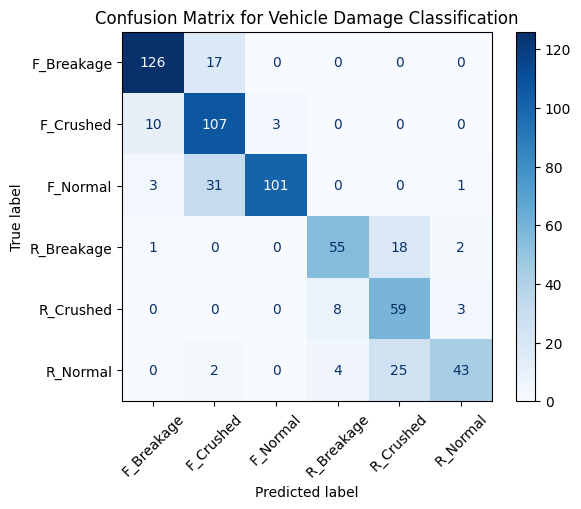

In [89]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [91]:
torch.save(
    model.state_dict(),
    '/content/drive/MyDrive/Colab Notebooks/Car_Damage_detection/saved_model_sree_varshan.pth'
)
